In [1]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Creating More Complex Clusters
Below we will create a spiral and a ball of points. Then we will demonstrate why K-Means Clustering is not a good fit for this type of data.

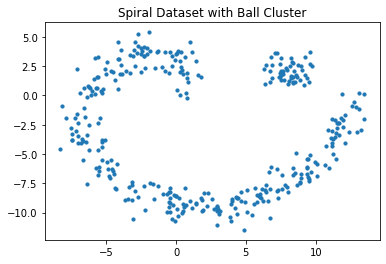

In [2]:
def generate_spiral(n_points=300, noise=.75):
    theta = np.sqrt(np.random.rand(n_points)) * 2 * np.pi  # Angle component
    r = 2 * theta  # Radius component
    x = r * np.cos(theta) + np.random.normal(0, noise, n_points)
    y = r * np.sin(theta) + np.random.normal(0, noise, n_points)
    return np.vstack((x, y)).T



def generate_ball(n_points=50, center=(8, 2), radius=0.3, noise=0.76):
    angle = 2 * np.pi * np.random.rand(n_points)
    distance = radius * np.sqrt(np.random.rand(n_points))
    x = center[0] + distance * np.cos(angle) + np.random.normal(0, noise, n_points)
    y = center[1] + distance * np.sin(angle) + np.random.normal(0, noise, n_points)
    return np.vstack((x, y)).T



# Create datasets
np.random.seed(16)
X_spiral = generate_spiral()
X_ball = generate_ball()

# Combine datasets
X = np.vstack((X_spiral, X_ball))

# Plot the dataset
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title("Spiral Dataset with Ball Cluster")
plt.show()

If we were to attempt to cluster this with K-Means using two clusters (one for our ball and one for our cluster), it will split our spiral in half and cluster our ball with the right half.

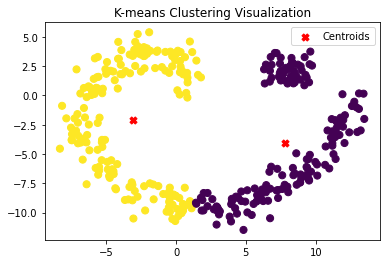

In [3]:
kmeans = KMeans(n_clusters=2, random_state=16)
y_kmeans = kmeans.fit_predict(X)

# Plot the clustered data
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=50, label='Centroids')
plt.title('K-means Clustering Visualization')
plt.legend()
plt.show()

In fact the first time that the ball is clustered by itself using the seed 16 is when $k=7$, at which point the spiral is completely overly divided. Thus k-means clustering is completely inadequate for determining the deeper underlying density clustering of our data. We need a different approach.

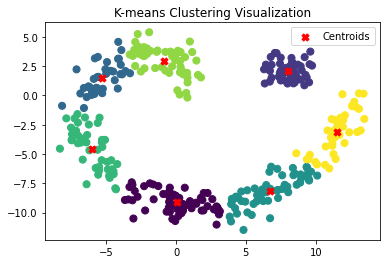

In [4]:
kmeans = KMeans(n_clusters=7, random_state=16)
y_kmeans = kmeans.fit_predict(X)

# Plot the clustered data
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=50, label='Centroids')
plt.title('K-means Clustering Visualization')
plt.legend()
plt.show()

# DBSCAN
The way that Density Based Spacial Clustering with Applications & Noise works is by first selecting two hyperparameters $\varepsilon$ & $k$. Here $\varepsilon$ represents the furtherest distance that two points can be while still being considered close to each other (neighbors) and $k$ determines the number of neighbors a point needs to be considered a core point.


* Chose a point
* draw $\varepsilon-$ball around our point
    * Any points in this ball
* A core point is close to at leaast $k$ other points
* Find all core points
* Randomly select a core point and assign it to cluser 1
* Add all core points close to our initial core point to cluster 1
    * Repeat this absorbing core points into the cluster
    * For non-core points close to first cluster, we do not add them <ins>yet</ins>
* Then we add all the non-core points that are close to the cluster
    * We do not add points that are close to non-core cluster points
    * ie only core points can add new points to cluster
* If we have left over core points, repeat above for cluster 2 and so on
* Once there are no more core points, all remaining points are labeled as noise

We will implement this using a helper function called region_query that gets all of the neigbhors of a point. We will also use double ended queues in our code to efficiently remove points and add points to our lists of neighbors.

In [5]:
def region_query(X, index, eps):
    """
    Takes data X, index of a point, and eps value in order to 
    return index of all neighboring points
    """
    nbrs = []
    for i in range(X.shape[0]):
        if np.linalg.norm(X[i] - X[index]) < eps:
            nbrs.append(i)
    return nbrs


In [6]:
class DBSCAN:
    def __init__(self, eps, k):
        self.eps = eps
        self.k = k
    
    def fit(self, X):
        """
        Fits DBSCAN on data X
        """
        # Initializes labels as -1 (noise)
        labels = np.full(X.shape[0], -1)  
        cluster_id = 0
        
        #iterate over every point
        for i in range(X.shape[0]):
            
            if labels[i] != -1:  # Skip if point is classified
                continue
            
            nbrs = region_query(X, i, self.eps)
            # If a point has less than k neighbors, classify it as noise
            if len(nbrs) < self.k:
                labels[i] = -1 
            else:
                queue = deque(nbrs)  # Use deque for efficiency
                labels[i] = cluster_id

                while queue:
                    nbr = queue.popleft()
                    if labels[nbr] == -1:  # Convert noise to border point
                        labels[nbr] = cluster_id
                    elif labels[nbr] != -1:
                        continue  # Skip already classified points

                    labels[nbr] = cluster_id
                    new_nbrs = region_query(X, nbr, self.eps)
                    if len(new_nbrs) >= self.k:
                        queue.extend(new_nbrs)  # Add new neighbors to queue
                
                #Start next cluster
                cluster_id += 1
        
        self.X = X
        self.labels = labels
        return labels
    
    def visualize(self):
        """ 
        Plots the classified points with noise in black and clusters
        unique colors.
        """
        unique_labels = set(self.labels)
        color_map = plt.cm.get_cmap("tab10", len(unique_labels))  # Generate distinct colors
        label_colors = {label: "black" if label == -1 else color_map(i) 
                        for i, label in enumerate(unique_labels)}

        plt.figure(figsize=(8, 6))

        for label in unique_labels:
            mask = (self.labels == label)  # Mask for selecting points of the cluster
            plt.scatter(self.X[mask][:, 0], self.X[mask][:, 1], color=label_colors[label], 
                        label=f"Cluster {label}" if label != -1 else "Noise")

        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.title("DBSCAN Classification Results")
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.show()


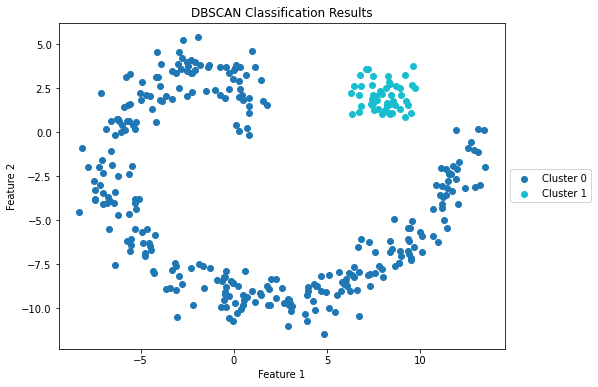

In [7]:
model = DBSCAN(1.5, 2) 
model.fit(X)
model.visualize()

As we can see, DBSCAN provides a more efficient way to classify the data. Using a distance of 1.5 to be considered neighbors anda required 2 points to be considered a core point, we get a perfect classification of our data. Let's try one more slightly harder example.

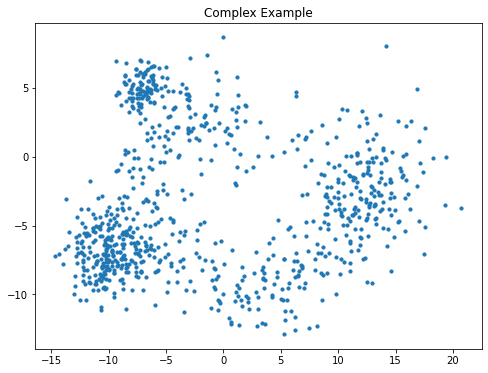

In [8]:
# Create datasets
np.random.seed(16)
X_spiral = generate_spiral(n_points=350, noise=1.75)
X_ball_1 = generate_ball(n_points=150, center=(12, -2), radius=2, noise=2.76)
X_ball_2 = generate_ball(n_points=250, center=(-10, -7), radius=0.3, noise=1.7)
X_ball_3 = generate_ball(n_points=100, center=(-7, 5), radius=0.01, noise=1)

# Combine datasets
X = np.vstack((X_spiral, X_ball_1, X_ball_2, X_ball_3))

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title("Complex Example")
plt.show()

Okay. Looking at this we have three obvious clusters: one in the bottom left at around (-10, -7) and one in the middle right around (-10, -2), and one at (-6,5). Let's just experiment with a few values of $\varepsilon$ and $k$ just to see what happens.

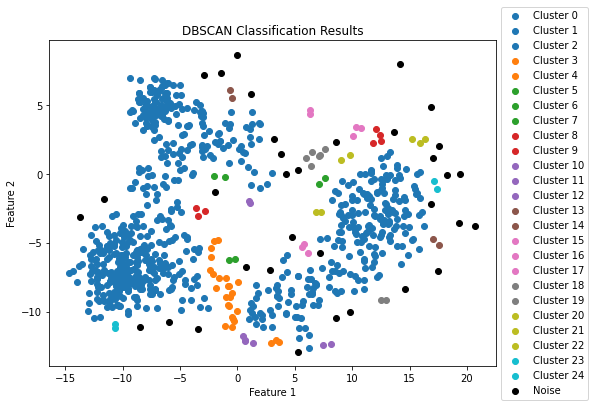

In [9]:
model = DBSCAN(1, 2) 
model.fit(X)
model.visualize()

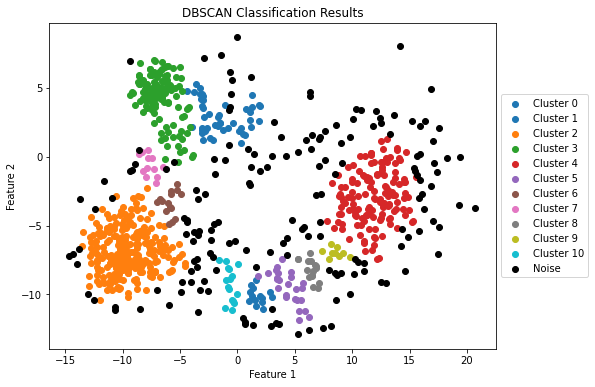

In [10]:
model = DBSCAN(1, 7) 
model.fit(X)
model.visualize()

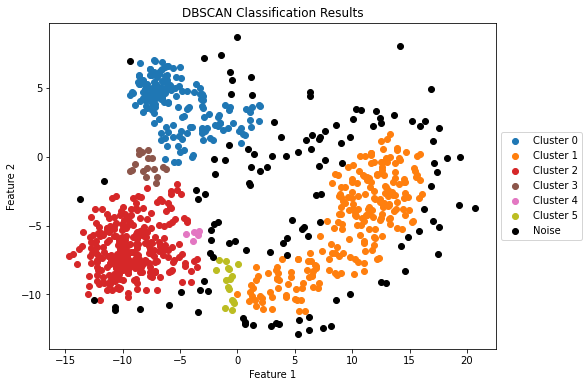

In [11]:
model = DBSCAN(1.2, 8) 
model.fit(X)
model.visualize()

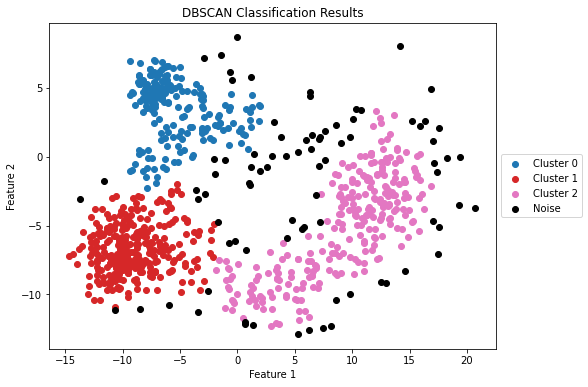

In [12]:
model = DBSCAN(1.28, 7) 
model.fit(X)
model.visualize()

# Takeaways
As we can see, small changes in $k$ and $\varepsilon$ can vastly change our classifications. I think our final classification is the best, but there is still a good amount of noise that has to be addressed. Like K-Means Clustering this is a hard problem to determine the best values for our hyperparameters (and this can be quite subjective), so this would require some trial and error as well as domain knowledge.